In [18]:
# Random initialization
import numpy as np
np.random.seed(98643)
import tensorflow as tf
# An image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

# Data reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Training Part
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator


첫 번째로 데이터 전처리를 해야합니다.

기본 아이디어는 데이터 세트에 제공된 이미지가 매우 노이즈가 많으며, 세분화된 노이즈를 제거할 경우 더 잘 예측하고 노이즈 데이터 세트를 구성할 수 있다는 것입니다.

모델 교육에 추가로 사용될 수 있는 몇 가지 글로벌 기능을 추출하기 위해 데이터 세트에서 노이즈 제거 자동 인코더를 교육하는 것도 괜찮습니다.

In [4]:
# Translate data to an image format
def color_composite(data):
    rgb_arrays=[]
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2
        
        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [6]:
train = pd.read_json('./input/train.json')
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

# These are train flags that required to train model more efficiently and select proper model parameters
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True or train_all

clean_all = False
clean_b = False or clean_all
clean_img= False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [9]:
def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.5, weigth_rgb=0.05, weight_gray=0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
    # Make a picture format from flat vector
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    if train_b and clean_b:
        # Smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 Done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 Done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 Done')
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
    print('RGB Done')
    tf_reshape = lambda x:np.asarray([item.reshape(75, 75, 1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    if labeled:
        y = np.array(frame['is_iceberg'])
    else:
        y = None
    return y, band, images

In [10]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB Done


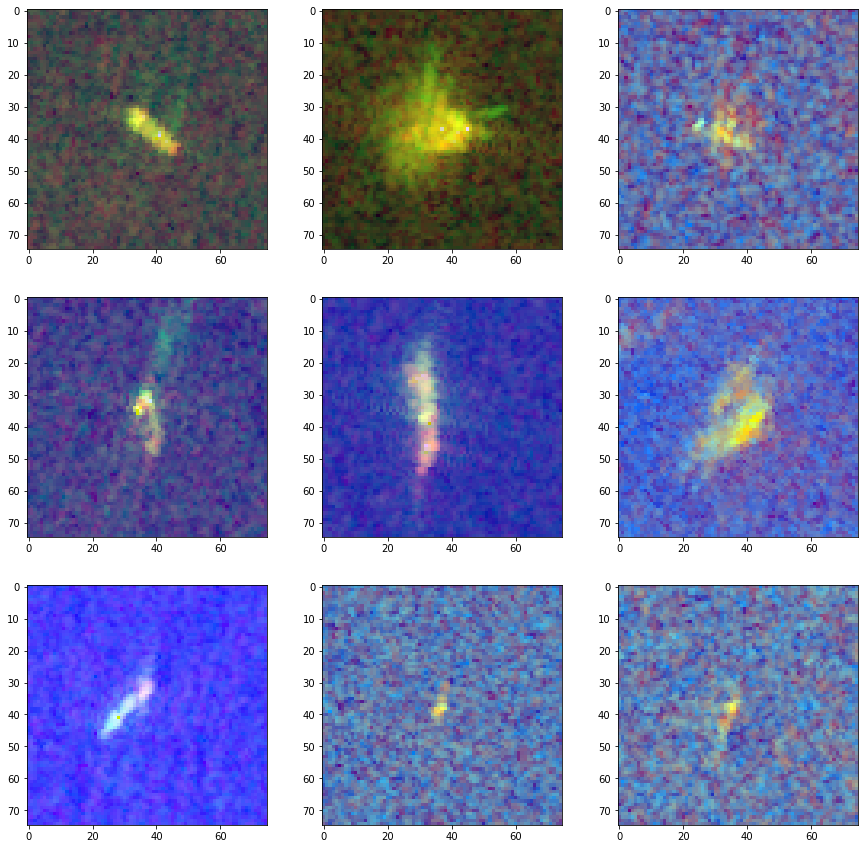

In [11]:
fig = plt.figure(200, figsize=(15, 15))
random_indices = np.random.choice(range(len(X_images)), 9, False)
subset = X_images[random_indices]
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(subset[i])
plt.show()

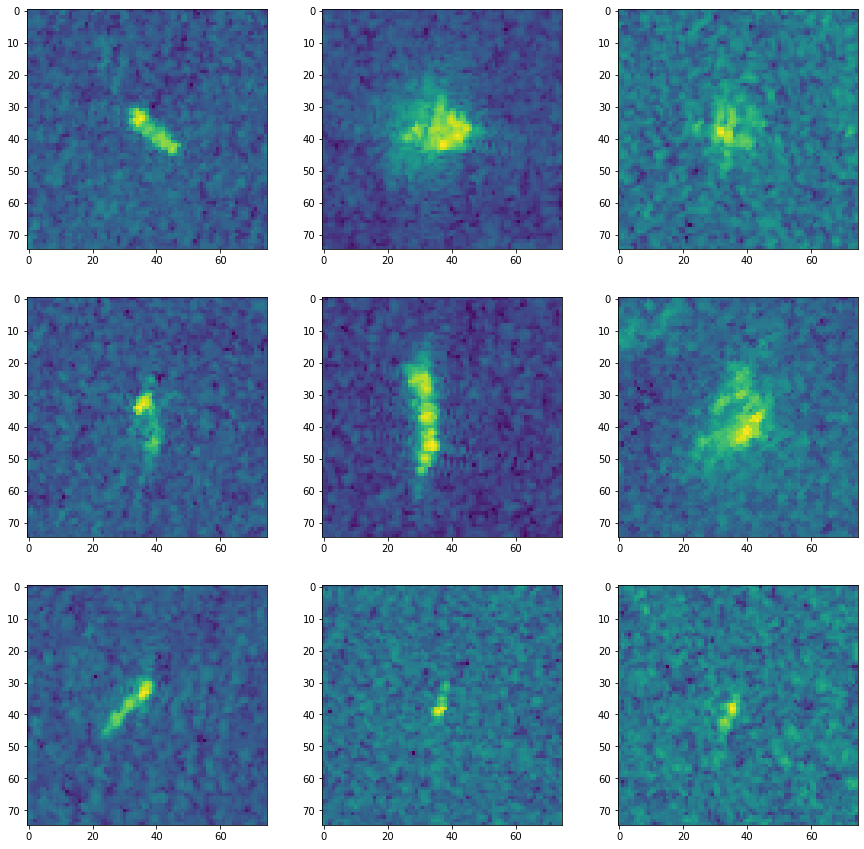

In [12]:
fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indices]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(subset[i])
plt.show()

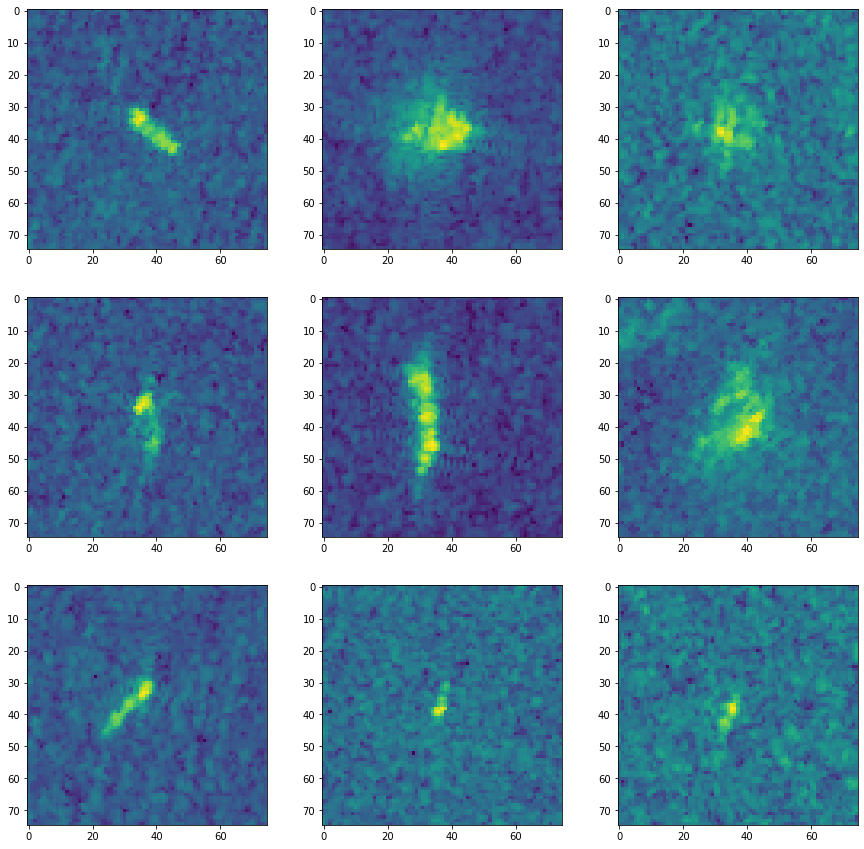

In [13]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indices]
subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(subset[i])
plt.show()

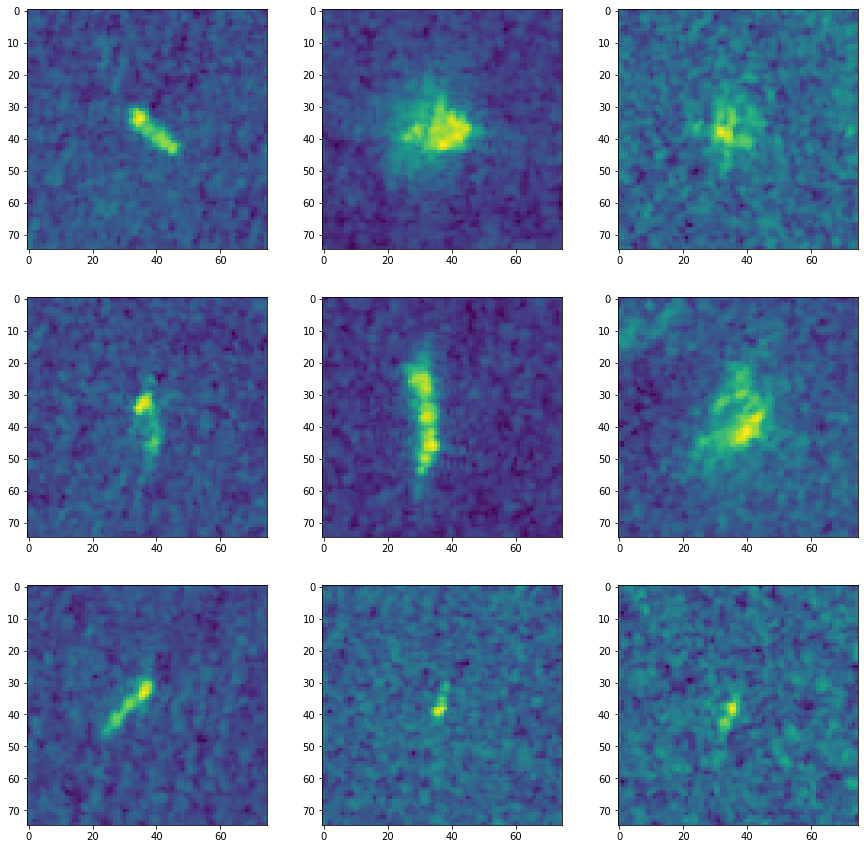

In [16]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indices]
subset = smooth(denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5) 
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(subset[i])
plt.show()

모델 자체는 3개의 컨볼루션 신경망으로 구성되어 있습니다. 두 개의 기본 네트워크와 한 개의 네트워크가 결합되었습니다. 이 아이디어는 서로 다른 데이터 표현에 대해 두 개의 기본 네트워크를 훈련시키고 그 후에 공통 네트워크를 훈련시키기 위해 훈련된 컨볼루션 레이어를 조합하여 사용하는 것입니다.

In [46]:
def get_model_notebook(lr, decay, channels, relu_type='relu'):
    # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape=(75, 75, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    # For some reason i've decided not to normalize angle data
    output = Dense(1, activation="sigmoid")(dense)
    model = Model(local_input, output)
    optimizer = Adam(lr=lr, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model, partial_model

In [47]:
def combined_model(m_b, m_img, lr, decay):
    input_b = Input(shape=(75, 75, 3))
    input_img = Input(shape=(75, 75, 3))

    # I've never tested non-trainable source models tho
    #for layer in m_b.layers:
    #    layer.trainable = False
    #for layer in m_img.layers:
    #    layer.trainable = False

    m1 = m_b(input_b)
    m2 = m_img(input_img)

    # So, combine models and train perceptron based on that
    # The iteresting idea is to use XGB for this task, but i actually hate this method
    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    common = Dense(1024, activation='relu')(common)
    common = Dropout(0.3)(common)
    common = Dense(512, activation='relu')(common)
    common = Dropout(0.3)(common)
    output = Dense(1, activation="sigmoid")(common)
    model = Model([input_b, input_img], output)
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [48]:
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    gen2 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    genI1 = gen1.flow(I1, y, batch_size=batch_size, seed=57, shuffle=False)
    genI2 = gen2.flow(I1, I2, batch_size=batch_size, seed=57, shuffle=False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        #print I1i[0].shape
        np.testing.assert_array_equal(I2i[0], I1i[0])
        yield [I1i[0], I2i[1]], I1i[1]

In [49]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose=2):
    callbacks = [ModelCheckpoint(checkpoint_name, save_best_only=True, monitor='val_loss')]
    datagen = ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                width_shift_range=0.,
                                height_shift_range=0.,
                                channel_shift_range=0,
                                zoom_range=0.2,
                                rotation_range=10)
    x_test, y_test = val_data
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,
                           steps_per_epoch = len(X_train)/batch_size,
                           validation_data = (x_test, y_test), verbose=1,
                           callbacks=callbacks)
        
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    model.load_weights(filepath=checkpoint_name)
    return model

In [50]:
#Train a particular model
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                           X_train, y_train, (X_test, y_test), verbose=verbose)

    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                               verbose=0, batch_size=batch_size)

        loss_train, acc_train = model.evaluate(X_test, y_test,
                                       verbose=0, batch_size=batch_size)

        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), \
            'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model


In [51]:
# Train all 3 models
def train_models(dataset, lr, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val,\
    X_b_full, X_b_val,\
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data=data_b1, verbose=verbose)

    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                       data_images, verbose=verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=30,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath='common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

In [52]:
common_model = train_models((y_train, X_b, X_images), 7e-04, 32, 50, 1, return_model=True)

Training bandwidth network


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
38/38 [==============================] - 12s 242ms/step - loss: 0.7036 - accuracy: 0.5413 - val_loss: 2.2759 - val_accuracy: 0.5253
INFO:tensorflow:Assets written to: model_b\assets
Epoch 2/50
38/38 [==============================] - 9s 229ms/step - loss: 0.6324 - accuracy: 0.6306 - val_loss: 0.7147 - val_accuracy: 0.5207
INFO:tensorflow:Assets written to: model_b\assets
Epoch 3/50
38/38 [==============================] - 9s 227ms/step - loss: 0.6042 - accuracy: 0.6322 - val_loss: 0.7319 - val_accuracy: 0.5253
Epoch 4/50
38/38 [==============================] - 9s 227ms/step - loss: 0.5776 - accuracy: 0.6944 - val_loss: 0.6413 - val_accuracy: 0.6037
INFO:tensorflow:Assets written to: model_b\assets
Epoch 5/50
38/38 [==============================] - 9s 235ms/step - loss: 0.5312 - accuracy: 0.6950 - val_loss: 0.6870 - val_accuracy: 0.5484
Epoch 6/50
38/38 [==============================] - 9s 232ms/step - loss: 0.5113 - accuracy: 0.7479 - val_loss: 0.5649 - val_accuracy: 0.66

OpError: 